## Fera Formidável 4.5
### Um momento, por favor!
#### Rômulo 24024

### Enunciado:
**Objetivo:** implemente o otimizador de Descida do Gradiente com Momento (Gradient
Descent with Momentum) na rede neural feita em Python puro.

**Comentário:** observe que o enunciado diz claramente que é para realizar a tarefa na
rede neural feita em Python puro nos vídeos da disciplina. Se você está usando o PyTorch,
numpy, tensorflow, keras, lightning ou qualquer outra biblioteca pronta, você está no
caminho errado!

### Introdução:

In [2]:
import pandas as pd
import random
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

dados = pd.read_csv('http://gist.githubusercontent.com/slopp/ce3b90b9168f2f921784de84fa445651/raw/4ecf3041f0ed4913e7c230758733948bc561f434/penguins.csv').dropna()

Classes usadas em Python puro:
Aqui vamos adicionar um p.momento, que armazena o termo do momento.

In [3]:
class Valor:
    def __init__(self, data, progenitor=(), operador_mae="", rotulo=""):
        self.data = data
        self.progenitor = progenitor
        self.operador_mae = operador_mae
        self.rotulo = rotulo
        self.grad = 0
        self.momento = 0 # Instância p.momento

    def __repr__(self):
        return f"Valor(data={self.data})"
    
    def __add__(self, outro_valor):
        """Realiza a operação: self + outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data + outro_valor.data
        operador_mae = "+"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_adicao():
            self.grad += resultado.grad
            outro_valor.grad += resultado.grad
            
        resultado.propagar = propagar_adicao
        
        return resultado
    
    def __mul__(self, outro_valor):
        """Realiza a operação: self * outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data * outro_valor.data
        operador_mae = "*"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_multiplicacao():
            self.grad += resultado.grad * outro_valor.data # grad_filho * derivada filho em relação a mãe
            outro_valor.grad += resultado.grad * self.data
            
        resultado.propagar = propagar_multiplicacao
        
        return resultado
    
    def exp(self):
        """Realiza a operação: exp(self)"""
        progenitor = (self, )
        data = np.exp(self.data) # Consertar math range error
        operador_mae = "exp"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_exp():
            self.grad += resultado.grad * data 
        
        resultado.propagar = propagar_exp
        
        return resultado
    
    def __pow__(self, expoente):
        """Realiza a operação: self ** expoente"""
        assert isinstance(expoente, (int, float))
        progenitor = (self, )
        data = self.data ** expoente
        operador_mae = f"**{expoente}"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_pow():
            self.grad += resultado.grad * (expoente * self.data ** (expoente - 1))
        
        resultado.propagar = propagar_pow
        
        return resultado
    
    def __truediv__(self, outro_valor):
        """Realiza a operação: self / outro_valor"""
        return self * outro_valor ** (-1)
    
    def __neg__(self):
        """Realiza a operação: -self"""
        return self * -1
    
    def __sub__(self, outro_valor):
        """Realiza a operação: self - outro_valor"""
        return self + (-outro_valor)
    
    def __radd__(self, outro_valor):
        """Realiza a operação: outro_valor + self"""
        return self + outro_valor
    
    def __rmul__(self, outro_valor):
        """Realiza a operação: outro_valor * self"""
        return self * outro_valor
    
    def sig(self):
        """Realiza a operação: exp(self) / (exp(self) + 1)"""
        return self.exp() / (self.exp() + 1)
    
    def propagar(self):
        pass
    
    def propagar_tudo(self, grau_aumento = 1):
        
        self.grad = 1
        
        ordem_topologica = []
        
        visitados = set()

        def constroi_ordem_topologica(v):
            if v not in visitados:
                visitados.add(v)
                for progenitor in v.progenitor:
                    constroi_ordem_topologica(progenitor)
                ordem_topologica.append(v)

        constroi_ordem_topologica(self)
        for vertice in reversed(ordem_topologica):
            vertice.propagar()
class Neuronio:
    def __init__(self, num_dados_entrada):
        self.vies = Valor(random.uniform(-1, 1))
        self.pesos = []
        for i in range(num_dados_entrada):
            self.pesos.append(Valor(random.uniform(-1, 1)))
            
    def __call__(self, x,dropout):
        
        assert len(x) == len(self.pesos)
        
        soma = 0
        for info_entrada, peso_interno in zip(x, self.pesos):
            soma += info_entrada * peso_interno
            
        soma += self.vies  
        # Probabilidade do neurônio ser desativado
        p = random.uniform(0,1)
        if p < dropout: # Se essa probabilidade sorteada for menor que a taxa de dropout o neurônio será desligado
            dado_de_saida = Valor(0) 
        else:
            dado_de_saida = soma.sig()

        return dado_de_saida       
    
    def parametros(self):
        return self.pesos + [self.vies]
    
class Camada:
    def __init__(self, num_neuronios, num_dados_entrada):
        neuronios = []
        
        for _ in range(num_neuronios):
            neuronio = Neuronio(num_dados_entrada)
            neuronios.append(neuronio)
            
        self.neuronios = neuronios     
        
    def __call__(self, x,dropout):
        dados_de_saida = []
        
        for neuronio in self.neuronios:
            informacao = neuronio(x,dropout)
            dados_de_saida.append(informacao)
            
        if len(dados_de_saida) == 1:
            return dados_de_saida[0]
        else:        
            return dados_de_saida  
    
    def parametros(self):
        params = []
        
        for neuronio in self.neuronios:
            params_neuronio = neuronio.parametros()
            params.extend(params_neuronio)
        
        return params
    
class MLP:
    def __init__(self, num_dados_entrada, num_neuronios_por_camada):
        
        percurso = [num_dados_entrada] + num_neuronios_por_camada
        
        camadas = []
        
        for i in range(len(num_neuronios_por_camada)):
            camada = Camada(num_neuronios_por_camada[i], percurso[i])
            camadas.append(camada)
            
        self.camadas = camadas
        
    def __call__(self, x,dropout = 0):
        for i, camada in enumerate(self.camadas):
            if i == 0 or i == len(self.camadas) - 1:
                x = camada(x, 0)
            else:
                x = camada(x, dropout)
        return x

    
    def parametros(self):
        params = []
        
        for camada in self.camadas:
            parametros_camada = camada.parametros()
            params.extend(parametros_camada)
            
        return params

#### Tratando os dados:
Selecionaremos as seguintes features:
- Comprimento do bico
- Comprimento da nadadeira
- Massa corporal
- Ano de análise

Após isso, faremos a normalização e criaremos o modelo MLP.

In [4]:
x = ['bill_length_mm', 'flipper_length_mm','body_mass_g','year']
y = ['bill_depth_mm']

x = dados.loc[:,x].values # Seleção do x com base nos features
y_true = dados.loc[:,y].values # Seleção do y_true com base no target

# Normalização:
x_scaler = StandardScaler() # usarei o standar scaler
x_scaler.fit(x)
 
y_scaler = StandardScaler()
y_scaler.fit(y_true)
 
x = x_scaler.transform(x).tolist()
y_true = y_scaler.transform(y_true).tolist()

# Arquitetura MLP:
NUM_DADOS_DE_ENTRADA = 4  
NUM_DADOS_DE_SAIDA = 1    
CAMADAS_OCULTAS = [3, 2]  

arquitetura_da_rede = CAMADAS_OCULTAS + [NUM_DADOS_DE_SAIDA]

minha_mlp = MLP(NUM_DADOS_DE_ENTRADA, arquitetura_da_rede) # Criando MLP

O momento está sendo atualizado a partir do produto do hiperparâmetro COEFICIENTE_DE_MOMENTO pelo momento anterior, subtraído do produto da taxa de aprendizado pelo gradiente.

In [ ]:
# Hiperparâmetros:
NUM_EPOCAS = 40
TAXA_DE_APRENDIZADO = 0.5
COEFICIENTE_DE_MOMENTO = 0.7
momentos = []
media_momentos = []
losses = []
for epoca in range(NUM_EPOCAS):
    # forward pass
    y_pred = []
    for exemplo in x:
        previsao = minha_mlp(exemplo)
        y_pred.append(previsao)
    
    # loss
    erros = []
    for yt, yp in zip(y_true[0], y_pred):
        residuo = yp - yt
        erro_quadratico = residuo ** 2
        erros.append(erro_quadratico) 
    loss = sum(erros)
    losses.append(loss.data)       
    # zero grad
    for p in minha_mlp.parametros():
        p.grad = 0

    # backpropagation
    loss.propagar_tudo()

    # atualiza parâmetro
    media = 0
    for p in minha_mlp.parametros():
        media += p.momento # Para plotagem
        momentos.append(p.momento) # Para a plotagem 
        p.momento = COEFICIENTE_DE_MOMENTO * p.momento - TAXA_DE_APRENDIZADO * p.grad # Cálculo do momento
        p.data += p.momento # Atualizando os dados a partir do momento
    media_momentos.append(media)
    # mostra resultado (opcional)
    print(epoca, y_pred)

0 Valor(data=0.226216904374818)
1 Valor(data=0.19018484271022612)
2 Valor(data=0.1329348579688446)
3 Valor(data=0.07369322427157594)
4 Valor(data=0.03069124754386579)
5 Valor(data=0.008824476988448744)
6 Valor(data=0.0012172630703444205)
7 Valor(data=1.8540776244692794e-05)
8 Valor(data=0.0008359851127771573)
9 Valor(data=0.001896361224093143)
10 Valor(data=0.0026475991101336947)
11 Valor(data=0.0030008209365010013)
12 Valor(data=0.003017868380379509)
13 Valor(data=0.0027963542886787376)
14 Valor(data=0.0024302982126358586)
15 Valor(data=0.0019978882381712663)
16 Valor(data=0.0015586384905730414)
17 Valor(data=0.0011538223171157602)
18 Valor(data=0.0008082421654341351)
19 Valor(data=0.0005327767753936488)
20 Valor(data=0.0003274728480954296)
21 Valor(data=0.0001849145699389305)
22 Valor(data=9.351459379603579e-05)


Gráfico dos momentos, cada um associado a um parâmetro, em cada época:

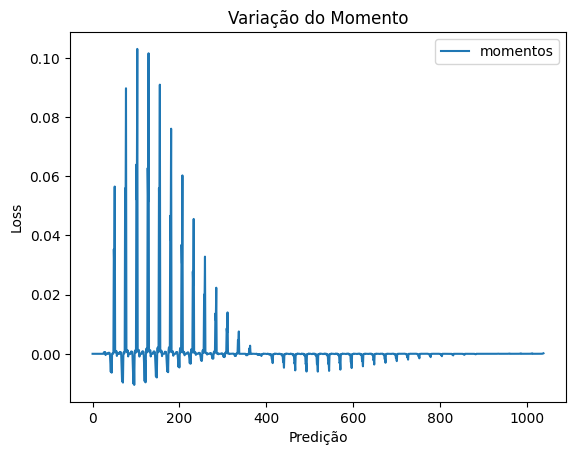

In [ ]:
plt.plot(momentos, label = 'momentos')
plt.xlabel('Predição')
plt.ylabel('Loss')
plt.title('Variação do Momento')
plt.legend()
plt.show()

Podemos ver, então, que o código está calculando corretamente o momento. Esta plotagem mostra o momento para todos os parâmetros, não trazendo informações comparativas, servindo apenas para mostrar que cada parâmetro tem um momento diferente associado e diferente de zero, o que sugere que o momento foi implementado corretamente.

Vamos agora fazer uma plotagem comparativa, na qual mostraremos a perda por época do treinamento do modelo e também a média dos momentos (há um associado a cada parâmetro da rede), para compararmos seus comportamentos em cada época.

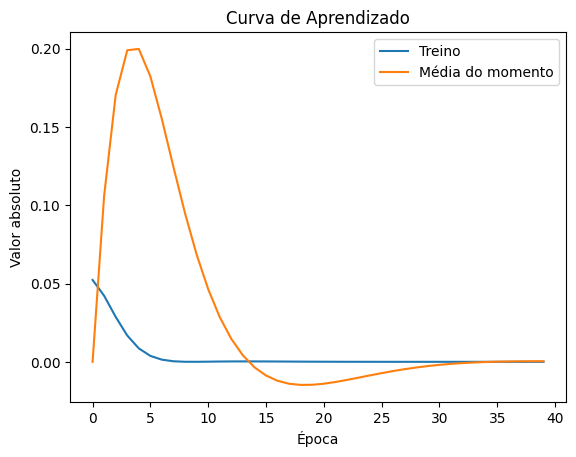

In [ ]:
plt.plot(losses, label='Treino')
plt.plot(media_momentos, label='Média do momento')
plt.xlabel('Época')
plt.ylabel('Valor absoluto')
plt.title('Curva de Aprendizado')
plt.legend()
plt.show()

Podemos observar que o momento se inicia baixo e tende a ganhar valor ao longo das épocas, até que o modelo se ajuste bem, e então o momento tende a cair e estabilizar perto de zero após esse ajuste. Por volta da época 7, a perda já está estabilizada, o que indica um treino favorável (seria necessário analisar mais informações para confirmar), mas o comportamento natural do momento é continuar variando (a taxa de momento está alta), portanto ele continua decaindo, chega a ter valor negativo, depois sobe novamente até convergir próximo de zero. Claramente, neste modelo houve sobreajuste, pois o número de épocas foi excessivo para analisarmos o comportamento do momento. Foi interessante perceber que as variações no momento, a partir de certa época, não interferiram visivelmente na perda do modelo.

### Conclusão:
A implementação demonstra que o momento foi corretamente calculado e aplicado, contribuindo para a eficiência do treinamento. Além disso, podemos analisar o comportamento oscilatório do momento, que realmente se assemelha ao de uma bolinha em uma rampa.

### Referências

- GEEKSFORGEEKS. ML | Momentum based Gradient Optimizer – Introduction. 

Disponível em: <https://www.geeksforgeeks.org/ml-momentum-based-gradient-optimizer-introduction/>
- Classes da MLP em Python puro

Obtidas em: ATP-303 NN 4.2 - Notebook MLP.ipynb